# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [12]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [22]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print(f"{t.round(2)} : {score.round(3)}")
    scores.append(score)

0.0 : 0.274
0.05 : 0.509
0.1 : 0.591
0.15 : 0.666
0.2 : 0.71
0.25 : 0.738
0.3 : 0.76
0.35 : 0.772
0.4 : 0.785
0.45 : 0.793
0.5 : 0.803
0.55 : 0.801
0.6 : 0.795
0.65 : 0.786
0.7 : 0.765
0.75 : 0.744
0.8 : 0.735
0.85 : 0.726
0.9 : 0.726
0.95 : 0.726
1.0 : 0.726


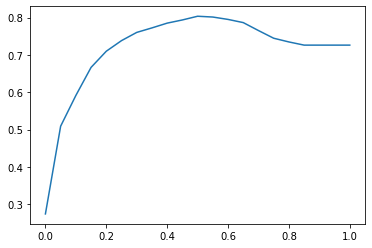

In [16]:
plt.plot(thresholds, scores)

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [26]:
scores = []

for t in thresholds:
    score = churn_decision = accuracy_score(y_val, y_pred >= t)
    print(f"{t.round(2)} : {score.round(3)}")
    scores.append(score)

0.0 : 0.274
0.05 : 0.509
0.1 : 0.591
0.15 : 0.666
0.2 : 0.71
0.25 : 0.738
0.3 : 0.76
0.35 : 0.772
0.4 : 0.785
0.45 : 0.793
0.5 : 0.803
0.55 : 0.801
0.6 : 0.795
0.65 : 0.786
0.7 : 0.765
0.75 : 0.744
0.8 : 0.735
0.85 : 0.726
0.9 : 0.726
0.95 : 0.726
1.0 : 0.726


In [27]:
from collections import Counter

In [28]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [29]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [30]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [31]:
actual_positive = (y_val ==1)
actual_negative = (y_val ==0)

In [32]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [33]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [34]:
predict_negative

array([ True,  True,  True, ...,  True, False, False])

In [37]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [38]:
tp, tn

(210, 922)

In [39]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [40]:
fp, fn

(101, 176)

In [41]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

In [42]:
confusion_matrix

array([[922, 101],
       [176, 210]])

In [44]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [47]:
#Precision: Fraction of Positive predictions that are correct
p = tp / (tp + fp)
p

0.6752411575562701

In [48]:
#Recall: Fraction of Correctly identified positive exemples
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and 

False Positive Rate (FPR) and True Postive Rate (TPR)

In [49]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [50]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [51]:
thresholds = np.linspace(0, 1, 101)

In [52]:
scores = []

for t in thresholds:
    actual_positive = (y_val ==1)
    actual_negative = (y_val ==0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [53]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 329, 341, 57, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 315, 304, 71, 719),
 (0.25, 309, 292, 77, 731),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [63]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

In [64]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [65]:
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [70]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


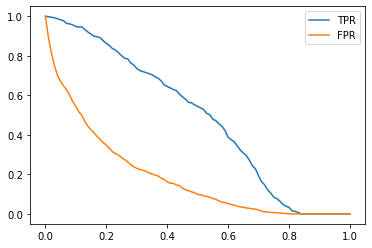

In [73]:
plt.plot(df_scores.threshold.to_numpy(), df_scores['tpr'].to_numpy(), label = 'TPR')
plt.plot(df_scores.threshold.to_numpy(), df_scores['fpr'].to_numpy(), label = 'FPR')
plt.legend()

### Random model

In [76]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [77]:
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [79]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [80]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    for t in thresholds:
        actual_positive = (y_val ==1)
        actual_negative = (y_val ==0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [81]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [82]:
df_rand

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,382,1013,4,10,0.989637,0.990225
2,0.02,379,993,7,30,0.981865,0.970674
3,0.03,375,979,11,44,0.971503,0.956989
4,0.04,372,969,14,54,0.963731,0.947214
...,...,...,...,...,...,...,...
96,0.96,14,41,372,982,0.036269,0.040078
97,0.97,11,36,375,987,0.028497,0.035191
98,0.98,8,19,378,1004,0.020725,0.018573
99,0.99,6,7,380,1016,0.015544,0.006843


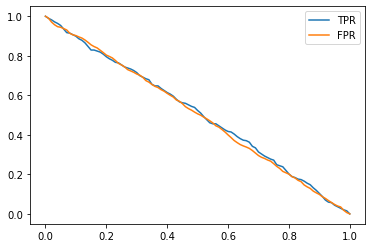

In [83]:
plt.plot(df_rand.threshold.to_numpy(), df_rand['tpr'].to_numpy(), label = 'TPR')
plt.plot(df_rand.threshold.to_numpy(), df_rand['fpr'].to_numpy(), label = 'FPR')
plt.legend()

#### Ideal model

In [85]:
num_neg = (y_val ==0).sum()
num_pos = (y_val ==1).sum()
num_neg, num_pos

(1023, 386)

In [86]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [88]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [91]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [92]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [93]:
df_ideal

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,386,1008,0,15,1.000000,0.985337
2,0.02,386,994,0,29,1.000000,0.971652
3,0.03,386,980,0,43,1.000000,0.957967
4,0.04,386,966,0,57,1.000000,0.944282
...,...,...,...,...,...,...,...
96,0.96,57,0,329,1023,0.147668,0.000000
97,0.97,43,0,343,1023,0.111399,0.000000
98,0.98,29,0,357,1023,0.075130,0.000000
99,0.99,15,0,371,1023,0.038860,0.000000


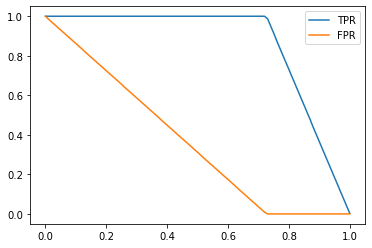

In [94]:
plt.plot(df_ideal.threshold.to_numpy(), df_ideal['tpr'].to_numpy(), label = 'TPR')
plt.plot(df_ideal.threshold.to_numpy(), df_ideal['fpr'].to_numpy(), label = 'FPR')
plt.legend()

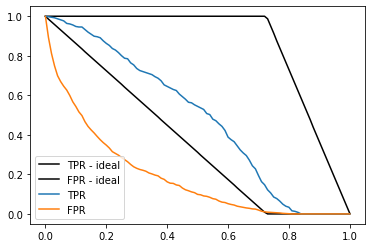

In [96]:
plt.plot(df_ideal.threshold.to_numpy(), df_ideal['tpr'].to_numpy(), label = 'TPR - ideal', color = 'black')
plt.plot(df_ideal.threshold.to_numpy(), df_ideal['fpr'].to_numpy(), label = 'FPR - ideal', color = 'black')
plt.plot(df_scores.threshold.to_numpy(), df_scores['tpr'].to_numpy(), label = 'TPR')
plt.plot(df_scores.threshold.to_numpy(), df_scores['fpr'].to_numpy(), label = 'FPR')
plt.legend()

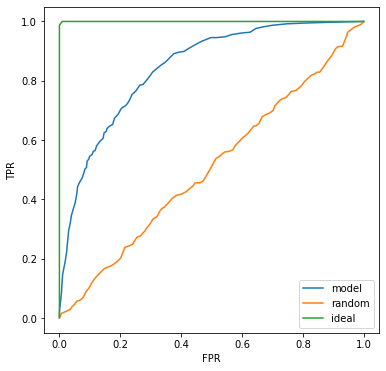

In [102]:
plt.figure(figsize=(6, 6))

plt.plot(df_scores.fpr.to_numpy(), df_scores.tpr.to_numpy(), label='model')
plt.plot(df_rand.fpr.to_numpy(), df_rand.tpr.to_numpy(), label='random')
plt.plot(df_ideal.fpr.to_numpy(), df_ideal.tpr.to_numpy(), label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

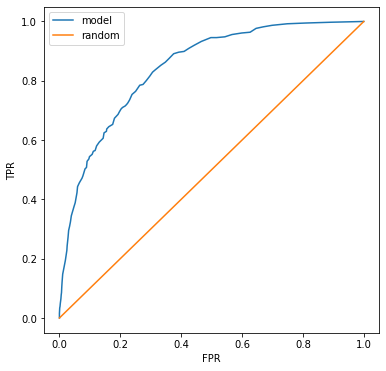

In [104]:
# ROC curve
plt.figure(figsize=(6, 6))

plt.plot(df_scores.fpr.to_numpy(), df_scores.tpr.to_numpy(), label='model')
plt.plot([0, 1], [0, 1], label='random')


plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [105]:
from sklearn.metrics import roc_curve

In [107]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

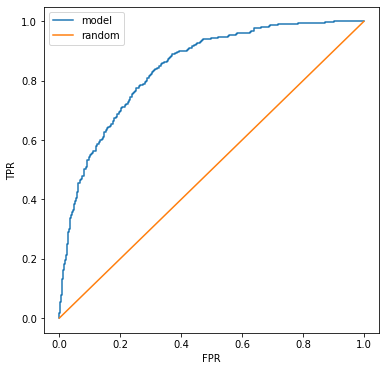

In [108]:
# ROC curve
plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')


plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

In [109]:
from sklearn.metrics import auc

In [110]:
auc(fpr, tpr)

0.8438479732980819

In [111]:
from sklearn.metrics import roc_auc_score

In [112]:
roc_auc_score(y_val, y_pred)

0.8438479732980819

In [113]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [114]:
import random

In [118]:
pos_ind = random.randint(0, len(pos) - 1)
neg_ind = random.randint(0, len(neg) - 1)

In [119]:
pos[pos_ind] > neg[neg_ind]

True

In [121]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success +=1
        
success / n

0.84436

In [124]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

In [125]:
neg[neg_ind]

array([0.19866916, 0.40373974, 0.30497014, ..., 0.00928659, 0.30601636,
       0.03613704])

In [127]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.844

## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [177]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [179]:
dv, model = train(df_train, y_train, C=0.001)

In [156]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [157]:
y_pred = predict(df_val, dv, model)

In [136]:
from sklearn.model_selection import KFold

In [158]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [159]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [160]:
len(train_idx), len(val_idx)

(5070, 564)

In [161]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [162]:
df_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [165]:
!pip install tqdm

In [166]:
from tqdm.auto import tqdm

In [182]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.006
C=1 0.841 +- 0.009
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008



In [175]:
print(f"{np.mean(scores):.3f} +- {np.std(scores):.3f}")

0.841 +- 0.012


In [183]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)

In [184]:
auc

0.8572386167896259